In [3]:
import pandas as pd
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import ast

In [4]:
df_t = pd.read_csv('../Data/ConservedRegions_kmeans_t.tsv', sep = '\t')
df_t

,Site,H,Region,Variant,Group
0,1,0.597737,5'UTR,Global,Variable
1,2,0.325213,5'UTR,Global,Variable
2,3,0.219767,5'UTR,Global,Semi-conserved
3,4,0.381892,5'UTR,Global,Variable
4,5,0.239893,5'UTR,Global,Semi-conserved
...,...,...,...,...,...
5429,29899,-0.000000,3'UTR,"(2023-07-01,2023-09-06]",High-conserved
5430,29900,-0.000000,3'UTR,"(2023-07-01,2023-09-06]",High-conserved
5431,29901,-0.000000,3'UTR,"(2023-07-01,2023-09-06]",High-conserved
5432,29902,-0.000000,3'UTR,"(2023-07-01,2023-09-06]",High-conserved


# Identificación de estructuras secundarias
* "." No forman estructura secundaria.
* "(", ")" Un paréntesis abierto y un paréntesis cerrado que están al mismo nivel indican un par de bases. Por ejemplo, en la secuencia ((..)), los dos nucleótidos en las posiciones 1 y 6 forman un par de bases, al igual que los nucleótidos en las posiciones 2 y 5.

In [5]:
files = os.listdir('../Data/concensus_seq/')

expr = r".*\.txt$"
files = [cadena for cadena in files if re.search(expr, cadena)]
files[0:3]

['concensus_predict_fold.txt',
 'concensus_sequence_19A_predict_fold.txt',
 'concensus_sequence_19B_predict_fold.txt']

In [6]:
def contar_caracteres(string):
    return ['fold' if s in '()' else 'non-fold' for s in string]

df_db = pd.DataFrame()
for filename in files:
    num = 1
    if filename == 'concensus_predict_fold.txt':
        ID = 'Global'
    elif filename == 'ref_predict_fold.txt':
        ID = 'reference'
        num = 2
    else:
        ID = filename.replace('concensus_sequence_', '').replace('_predict_fold.txt', '')
    with open('../Data/concensus_seq/' + filename) as file:
        content = file.read()
        content = content.split('\n')[num].split(' ')[0]
        
    fold = contar_caracteres(content)
    df_i = pd.DataFrame({'Site': list(range(1, len(fold)+1)), 'Structure':fold, 'Variant':[ID]*len(fold)})
    df_db = pd.concat([df_db, df_i])
df_db

,Site,Structure,Variant
0,1,non-fold,Global
1,2,non-fold,Global
2,3,non-fold,Global
3,4,non-fold,Global
4,5,non-fold,Global
...,...,...,...
29898,29899,non-fold,reference
29899,29900,non-fold,reference
29900,29901,non-fold,reference
29901,29902,non-fold,reference


In [11]:
# Regiones
#5'UTR	1	265	reg	.
#3'UTR	29675	29903	reg	.

df_db[(df_db['Variant'] == '23A') & (df_db['Structure']=='fold')&(df_db['Site']<=265)]
#df_db[(df_db['Variant'] == '23A') & (df_db['Structure']=='fold')&(df_db['Site']>=29675)]
#df_db[(df_db['Variant'] == '23F') & (df_db['Structure']=='fold')]

,Site,Structure,Variant
6,7,fold,23A
7,8,fold,23A
8,9,fold,23A
9,10,fold,23A
10,11,fold,23A
...,...,...,...
260,261,fold,23A
261,262,fold,23A
262,263,fold,23A
263,264,fold,23A


# Merge in variants

In [2]:
df_v = pd.read_csv('../Data/ConservedRegions_kmeans_v.tsv', sep = '\t')
df_sv = pd.merge(df_v, df_db, on=['Site', 'Variant'])
df_sv

NameError: name 'df_db' is not defined

# Identificación de estructuras secundarias conservadas

In [7]:
df_in_sv = pd.DataFrame(df_sv.groupby(by=['Site', 'Structure'])[['Site', 'Structure', 'Region']].value_counts()).reset_index()
df_in_sv

,Site,Structure,Region,0
0,1,non-fold,5'UTR,39
1,2,non-fold,5'UTR,39
2,3,non-fold,5'UTR,39
3,4,non-fold,5'UTR,39
4,5,non-fold,5'UTR,39
...,...,...,...,...
737,29899,non-fold,3'UTR,39
738,29900,non-fold,3'UTR,39
739,29901,non-fold,3'UTR,39
740,29902,non-fold,3'UTR,39


In [8]:
df_in_sv[(df_in_sv['Structure']=='fold') & (df_in_sv[0]==39)]

,Site,Structure,Region,0
7,7,fold,5'UTR,39
8,8,fold,5'UTR,39
9,9,fold,5'UTR,39
18,14,fold,5'UTR,39
19,15,fold,5'UTR,39
...,...,...,...,...
582,29805,fold,3'UTR,39
630,29830,fold,3'UTR,39
633,29832,fold,3'UTR,39
678,29855,fold,3'UTR,39


In [9]:
len(df_in_sv[(df_in_sv['Structure']=='fold') & (df_in_sv[0]==39) & (df_in_sv['Region']=="3'UTR")])

22

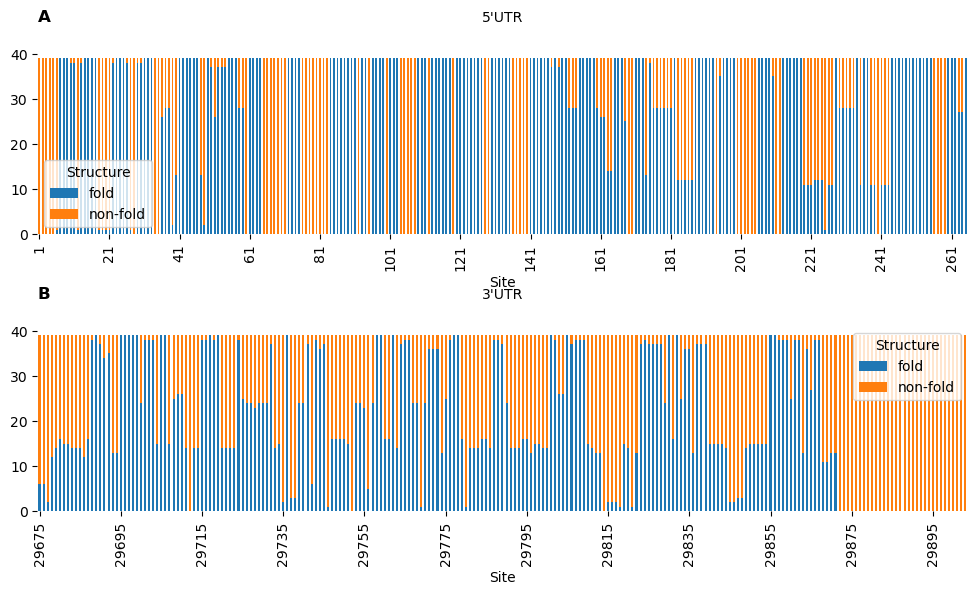

In [87]:
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(2, 1)

# 5 UTR
ax1 = fig.add_subplot(gs[0, 0])
df_filtered = df_in_sv[df_in_sv['Region']=="5'UTR"]
df_pivot = df_filtered.pivot_table(index='Site', columns='Structure', values=0, aggfunc='sum').fillna(0)

#ax1 = sns.lineplot(data=df_filtered[df_filtered['Structure']=='fold'], x = 'Site', y = 0, color='red')

min_val = df_pivot.index.min()
max_val = df_pivot.index.max()

sites = list(range(min_val, max_val+1, 20))
df_pivot.plot(kind='bar', stacked=True, ax=ax1)


ax1.set_xticks([df_pivot.index.get_loc(site) for site in sites if site in df_pivot.index])

plt.title('A', fontweight="bold", loc = 'left')
plt.title("5'UTR", fontsize=10, pad=20)

# Elimina los bordes del gráfico
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)

plt.subplots_adjust(hspace=0.5)




#3 UTR
ax2 = fig.add_subplot(gs[1, 0])
df_filtered2 = df_in_sv[df_in_sv['Region']=="3'UTR"]
df_pivot2 = df_filtered2.pivot_table(index='Site', columns='Structure', values=0, aggfunc='sum').fillna(0)

#ax1 = sns.lineplot(data=df_filtered[df_filtered['Structure']=='fold'], x = 'Site', y = 0, color='red')

min_val2 = df_pivot2.index.min()
max_val2 = df_pivot2.index.max()

sites2 = list(range(min_val2, max_val2+1, 20))
df_pivot2.plot(kind='bar', stacked=True, ax=ax2)


ax2.set_xticks([df_pivot2.index.get_loc(site) for site in sites2 if site in df_pivot2.index])

plt.title('B', fontweight="bold", loc = 'left')
plt.title("3'UTR", fontsize=10, pad=20)

# Elimina los bordes del gráfico
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

plt.subplots_adjust(hspace=0.5)


plt.savefig('../Plots/FoldComparative_v.pdf')

# Filtro

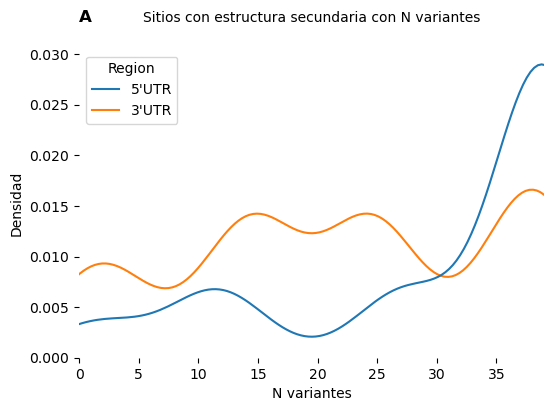

In [63]:
fig = plt.figure(figsize=(6, 4))
gs = gridspec.GridSpec(1, 1)


ax2 = fig.add_subplot(gs[0, 0])
sns.kdeplot(data=df_in_sv, x=0, hue='Region', ax=ax2)
ax2.set_xlim([0, df_in_sv[0].max()])
plt.xlabel('N variantes')
plt.ylabel('Densidad')
plt.title("A", fontweight="bold", loc = 'left')
ax2.set_title('Sitios con estructura secundaria con N variantes', fontsize=10, pad=20)

#delete box
sns.despine(left=True, bottom=True)
plt.savefig('../Plots/ConteoEstructurasSecundarias.pdf')

In [10]:
quitar = list(df_in_sv[(df_in_sv[0]==11) & (df_in_sv['Structure']=='fold')]['Site'])


df_svf = df_sv[(df_sv['Group']=='High-conserved')]
df_svf = df_svf[~df_svf['Site'].isin(quitar)]
df_svf

,Site,H,Region,Variant,Group,Structure
30,31,0.020671,5'UTR,Global,High-conserved,fold
31,32,0.005547,5'UTR,Global,High-conserved,fold
32,33,0.008934,5'UTR,Global,High-conserved,fold
33,34,0.012441,5'UTR,Global,High-conserved,non-fold
34,35,0.019033,5'UTR,Global,High-conserved,non-fold
...,...,...,...,...,...,...
19261,29899,-0.000000,3'UTR,recombinant,High-conserved,non-fold
19262,29900,-0.000000,3'UTR,recombinant,High-conserved,non-fold
19263,29901,-0.000000,3'UTR,recombinant,High-conserved,non-fold
19264,29902,-0.000000,3'UTR,recombinant,High-conserved,non-fold


In [11]:
quitar

[219, 220, 221, 226, 227, 235, 238, 239, 241, 242, 243, 29868, 29869]

In [89]:
df_tf = df_t[(df_t['Group']=='High-conserved')]
df_tf

,Site,H,Region,Variant,Group
30,31,0.020671,5'UTR,Global,High-conserved
31,32,0.005547,5'UTR,Global,High-conserved
32,33,0.008934,5'UTR,Global,High-conserved
33,34,0.012441,5'UTR,Global,High-conserved
34,35,0.019033,5'UTR,Global,High-conserved
...,...,...,...,...,...
5429,29899,-0.000000,3'UTR,"(2023-07-01,2023-09-06]",High-conserved
5430,29900,-0.000000,3'UTR,"(2023-07-01,2023-09-06]",High-conserved
5431,29901,-0.000000,3'UTR,"(2023-07-01,2023-09-06]",High-conserved
5432,29902,-0.000000,3'UTR,"(2023-07-01,2023-09-06]",High-conserved


# Identificacion de regiones conservadas consecutivas

In [90]:
def extract_consecutive(df):
    lst_variants = []
    for i in df['Variant'].unique():
        df_i = df[(df['Variant']==i)]
        sitios = list(df_i['Site'])
        lst_sitios_consecutivos = []
        lst = []
        for j in range(len(sitios)-1):
            if sitios[j]+1 != sitios[j+1]:
                lst_sitios_consecutivos.append(list(set(lst)))
                lst = []
            else:
                lst.append(sitios[j])
                lst.append(sitios[j+1])
        
        lst_sitios_consecutivos.append(list(set(lst)))
        lst_sitios_consecutivos = [sublista for sublista in lst_sitios_consecutivos if len(sublista) >= 4]
        lst_variants.append(lst_sitios_consecutivos)
    variantes = df['Variant'].unique(); df_bd = pd.DataFrame()
    for i in range(len(variantes)):
        df_i = pd.DataFrame({'Variante':variantes[i],
                             'RegionesConservadas':lst_variants[i]})
        df_bd = pd.concat([df_bd, df_i])
    return df_bd

In [91]:
df_conserved_tf = extract_consecutive(df_tf)
df_conserved_tf

,Variante,RegionesConservadas
0,Global,"[31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 4..."
1,Global,"[175, 176, 177, 178, 179, 180, 181, 182, 183, ..."
2,Global,"[205, 206, 207, 208, 209]"
3,Global,"[211, 212, 213, 214, 215, 216, 217, 218, 219, ..."
4,Global,"[224, 225, 226, 227, 228, 229, 230, 231, 232, ..."
...,...,...
14,"(2023-07-01,2023-09-06]","[29776, 29777, 29778, 29775]"
15,"(2023-07-01,2023-09-06]","[29824, 29825, 29826, 29827, 29828, 29829, 298..."
16,"(2023-07-01,2023-09-06]","[29856, 29857, 29858, 29859, 29860, 29861, 298..."
17,"(2023-07-01,2023-09-06]","[29863, 29864, 29865, 29866, 29867]"


In [68]:
df_conserved_v = extract_consecutive(df_svf)
df_conserved_v

,Variante,RegionesConservadas
0,Global,"[31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 4..."
1,Global,"[175, 176, 177, 178, 179, 180, 181, 182, 183, ..."
2,Global,"[205, 206, 207, 208, 209]"
3,Global,"[211, 212, 213, 214, 215, 216, 217, 218]"
4,Global,"[228, 229, 230, 231, 232, 233, 234]"
...,...,...
17,recombinant,"[29760, 29761, 29752, 29753, 29754, 29755, 297..."
18,recombinant,"[29763, 29764, 29765, 29766, 29767, 29768, 297..."
19,recombinant,"[29824, 29825, 29826, 29827, 29828, 29829, 298..."
20,recombinant,"[29859, 29860, 29861, 29862, 29863]"


In [69]:
df_conserved_tf.to_csv('../Data/RegionesConsecutivasConservadasTimes.tsv', sep = '\t', index = False)
df_conserved_v.to_csv('../Data/RegionesConsecutivasConservadasSinFoldVariants.tsv', sep = '\t', index = False)

# Inspect

In [123]:
df_conserved_tf = pd.read_csv('../Data/RegionesConsecutivasConservadasTimes.tsv', sep = '\t')
df_conserved_v = pd.read_csv('../Data/RegionesConsecutivasConservadasSinFoldVariants.tsv', sep = '\t')

In [140]:
lst = []; lst_region = []
for i in df_conserved_tf.RegionesConservadas:
    lst_i = ast.literal_eval(i)
    lst.append(len(lst_i))
    if int(lst_i[0]) <= 265:
        lst_region.append("5'UTR")
    else:
        lst_region.append("3'UTR")
        
df_conserved_tf['LenConserved'] = lst
df_conserved_tf['Region'] = lst_region
df_conserved_tf

,Variante,RegionesConservadas,LenConserved,Region
0,Global,"[31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 4...",143,5'UTR
1,Global,"[175, 176, 177, 178, 179, 180, 181, 182, 183, ...",26,5'UTR
2,Global,"[205, 206, 207, 208, 209]",5,5'UTR
3,Global,"[211, 212, 213, 214, 215, 216, 217, 218, 219, ...",11,5'UTR
4,Global,"[224, 225, 226, 227, 228, 229, 230, 231, 232, ...",18,5'UTR
...,...,...,...,...
164,"(2023-07-01,2023-09-06]","[29776, 29777, 29778, 29775]",4,3'UTR
165,"(2023-07-01,2023-09-06]","[29824, 29825, 29826, 29827, 29828, 29829, 298...",62,3'UTR
166,"(2023-07-01,2023-09-06]","[29856, 29857, 29858, 29859, 29860, 29861, 298...",15,3'UTR
167,"(2023-07-01,2023-09-06]","[29863, 29864, 29865, 29866, 29867]",5,3'UTR


In [141]:
pd.DataFrame(df_conserved_tf['Variante'].value_counts()).std()

Variante    5.084737
dtype: float64

In [150]:
df_gt = pd.DataFrame(df_conserved_tf[['Variante', 'Region']].value_counts()).reset_index()
df_gt.groupby(by=['Region']).agg(['mean', 'std'])

/tmp/ipykernel_6788/3463552856.py:2: FutureWarning: ['Variante'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_gt.groupby(by=['Region']).agg(['mean', 'std'])


0          
            mean       std
Region                    
3'UTR   8.818182  3.458849
5'UTR   6.545455  1.916436

In [155]:
df_conserved_tf.groupby(by=['Region'])['LenConserved'].agg(['mean', 'std'])

,mean,std
Region,,
3'UTR,21.649485,21.905593
5'UTR,37.222222,50.228554


In [144]:
lst = []; lst_region = []
for i in df_conserved_v.RegionesConservadas:
    lst_i = ast.literal_eval(i)
    lst.append(len(lst_i))
    if int(lst_i[0]) <= 265:
        lst_region.append("5'UTR")
    else:
        lst_region.append("3'UTR")
        
df_conserved_v['LenConserved'] = lst
df_conserved_v['Region'] = lst_region
df_conserved_v

,Variante,RegionesConservadas,LenConserved,Region
0,Global,"[31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 4...",143,5'UTR
1,Global,"[175, 176, 177, 178, 179, 180, 181, 182, 183, ...",26,5'UTR
2,Global,"[205, 206, 207, 208, 209]",5,5'UTR
3,Global,"[211, 212, 213, 214, 215, 216, 217, 218]",8,5'UTR
4,Global,"[228, 229, 230, 231, 232, 233, 234]",7,5'UTR
...,...,...,...,...
586,recombinant,"[29760, 29761, 29752, 29753, 29754, 29755, 297...",10,3'UTR
587,recombinant,"[29763, 29764, 29765, 29766, 29767, 29768, 297...",16,3'UTR
588,recombinant,"[29824, 29825, 29826, 29827, 29828, 29829, 298...",76,3'UTR
589,recombinant,"[29859, 29860, 29861, 29862, 29863]",5,3'UTR


In [145]:
df_conserved_v['LenConserved'].mean()

28.68020304568528

In [146]:
pd.DataFrame(df_conserved_v['Variante'].value_counts()).std()

Variante    3.073986
dtype: float64

In [151]:
df_gv = pd.DataFrame(df_conserved_v[['Variante', 'Region']].value_counts()).reset_index()
df_gv.groupby(by=['Region']).agg(['mean', 'std'])

/tmp/ipykernel_6788/1008348626.py:2: FutureWarning: ['Variante'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_gv.groupby(by=['Region']).agg(['mean', 'std'])


0          
            mean       std
Region                    
3'UTR   7.410256  1.956339
5'UTR   7.743590  1.787647

In [154]:
df_conserved_v.groupby(by=['Region'])['LenConserved'].agg(['mean', 'std'])

,mean,std
Region,,
3'UTR,27.387543,25.870712
5'UTR,29.917219,42.120572
